In [1]:
from utils import generate_siso_data
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

In [2]:
y_train, u_train, y_test, u_test = generate_siso_data(n=1000, noise_level=0.05)

y_train, u_train = y_train.reshape(-1,1), u_train.reshape(-1,1)
y_test, u_test = y_test.reshape(-1,1), u_test.reshape(-1,1)

In [3]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

N_TERMS_INFO_CRITERIA = 5
U_LAGS = 2
Y_LAGS = 2
basis_function = Polynomial(degree=1)

model_aic = FROLS(
    order_selection=True,
    n_terms=N_TERMS_INFO_CRITERIA,
    extended_least_squares=False,
    ylag=Y_LAGS,
    xlag=U_LAGS,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)

model_bic = FROLS(
    order_selection=True,
    n_terms=N_TERMS_INFO_CRITERIA,
    extended_least_squares=False,
    ylag=Y_LAGS,
    xlag=U_LAGS,
    info_criteria="bic",
    estimator="least_squares",
    basis_function=basis_function,
)

model_aic.fit(X=u_train, y=y_train)
model_bic.fit(X=u_train, y=y_train)

/home/alqua/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/alqua/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5
  self.info_values = self.information_criterion(reg_matrix, y)


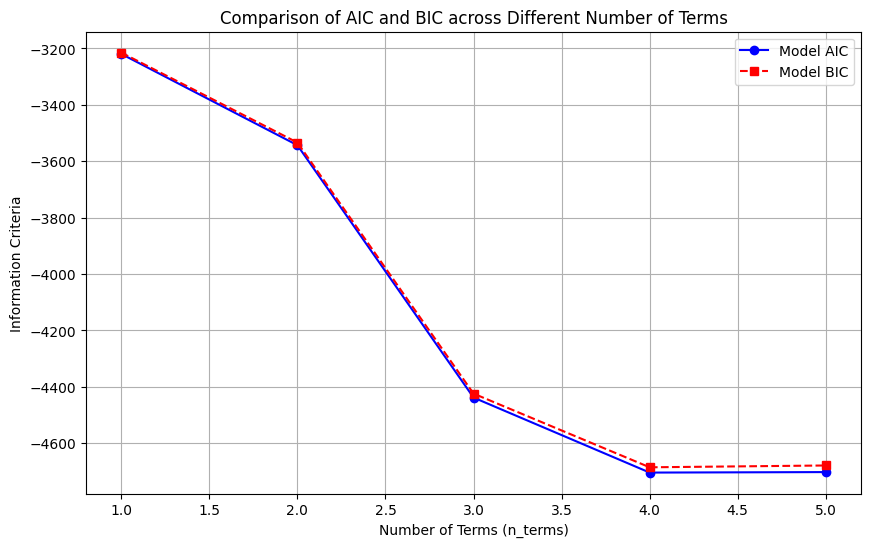

In [4]:
model_aic_info_values = model_aic.info_values
model_bic_info_values = model_bic.info_values
xaxis = np.arange(1, len(model_aic_info_values) + 1)

# Plotting the data
plt.figure(figsize=(10,6))
plt.plot(xaxis, model_aic_info_values, label='Model AIC', marker='o', linestyle='-', color='blue')
plt.plot(xaxis, model_bic_info_values, label='Model BIC', marker='s', linestyle='--', color='red')
plt.xlabel("Number of Terms (n_terms)")
plt.ylabel("Information Criteria")
plt.title("Comparison of AIC and BIC across Different Number of Terms")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
from sysidentpy.utils.display_results import results


yhat = model_aic.predict(X=u_test, y=y_test)

r = pd.DataFrame(
    results(
        model_aic.final_model,
        model_aic.theta,
        model_aic.err,
        model_aic.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

  Regressors   Parameters             ERR
0    x1(k-1)   7.0381E-01  9.28107103E-01
1     y(k-2)  -2.9709E-01  2.45182085E-02
2     y(k-1)   4.9732E-01  3.17585207E-02
3    x1(k-2)  -1.9991E-01  4.71170998E-03
4          1   2.1978E-03  4.13038857E-06


# Predict 

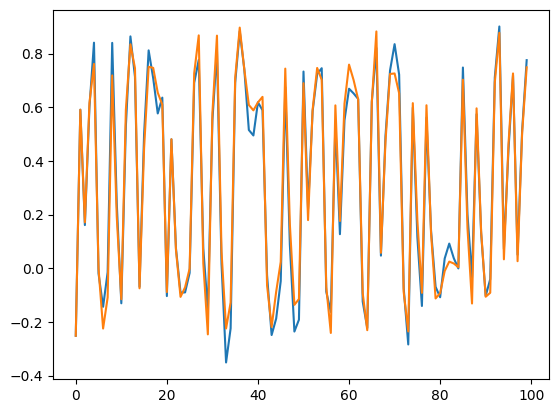

In [6]:
plt.plot(y_test[:100])
plt.plot(yhat[:100])

# Compute the error 

In [7]:
from sysidentpy.metrics import root_relative_squared_error

residuals = y_test - yhat

# Calculate the mean absolute error
mae = np.mean(np.abs(residuals))

# Calculate the mean squared error
mse = np.mean((residuals) ** 2)

# Calculate the root mean square error
rmse = np.sqrt(mse)

# Print the MAE, MSE, and RMSE with four decimal places
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
rrse = root_relative_squared_error(y_test, yhat)



MAE: 0.0459
MSE: 0.0033
RMSE: 0.0573


# Residuals Analysis 

### Residual Autocorrelation Test

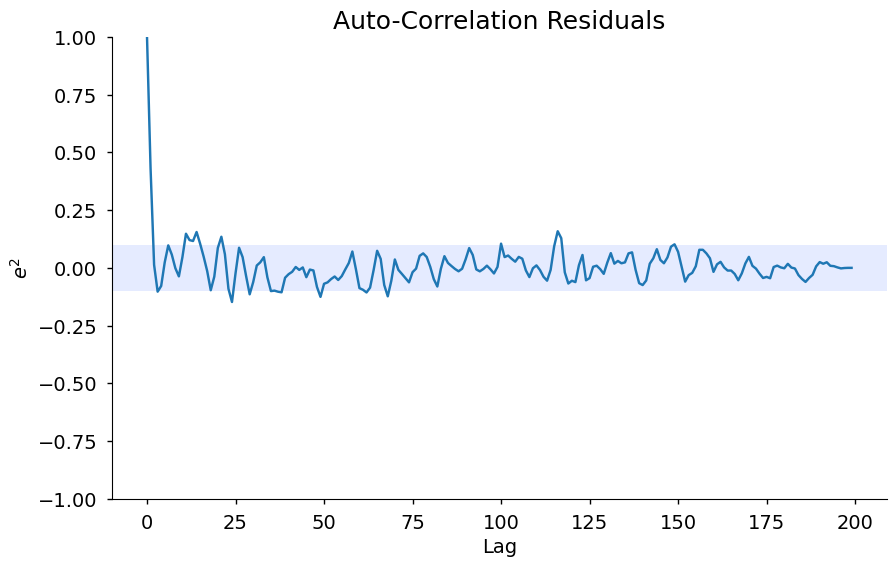

In [8]:
from sysidentpy.utils.plotting import plot_residues_correlation
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Auto-Correlation Residuals", ylabel="$e^2$", style='seaborn-v0_8-notebook')

### Residual Cross-Correlation Function

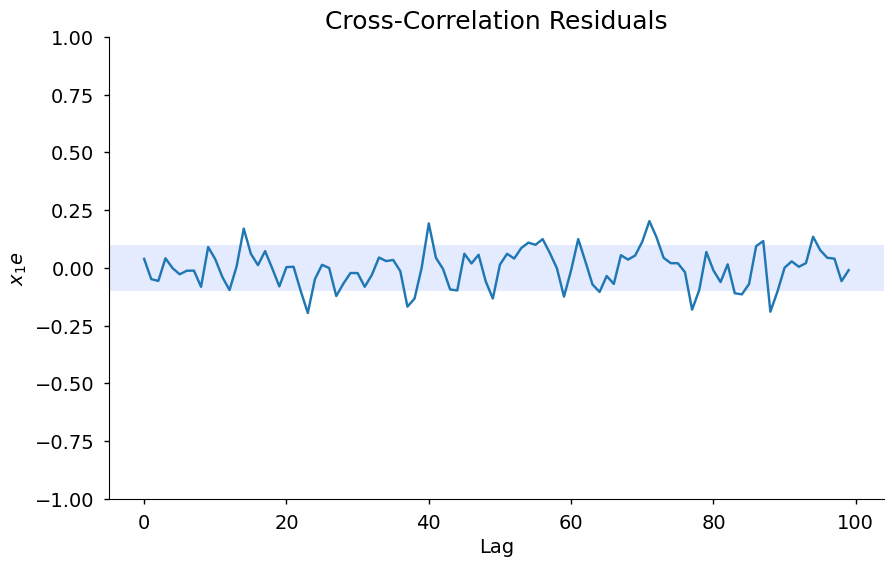

In [10]:
from sysidentpy.residues.residues_correlation import compute_cross_correlation

x1e = compute_cross_correlation(y_test, yhat, u_test)
plot_residues_correlation(data=x1e, title="Cross-Correlation Residuals", ylabel="$x_1e$", style='seaborn-v0_8-notebook')